In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from itertools import chain
import seaborn as sns
from datetime import datetime

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import torch.optim as optim
import h5py
# from torchsummary import summary
from tensorboardX import SummaryWriter

from IPython import display
%matplotlib inline

In [2]:
from src.dataloader import *

train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

In [3]:
model = 'resnet'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Model {model.capitalize()} is selected.')


if model == 'resnet':
    from src.architectures.resnet import *

    opt = Option()

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = generate_model(model_depth=opt.model_depth,
                                n_classes=opt.n_classes,
                                n_input_channels=opt.n_input_channels,
                                shortcut_type=opt.shortcut_type,
                                conv1_t_size=opt.conv1_t_size,
                                conv1_t_stride=opt.conv1_t_stride,
                                no_max_pool=opt.no_max_pool,
                                widen_factor=opt.resnet_widen_factor)
    
elif model == 'levakov':
    from src.architectures.levakov_96 import *

    model = Levakov(task_type='age')
    
else: pass
model.to(device)

Model Levakov is selected.


Levakov(
  (BN): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (3): ReLU()
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (3): ReLU()
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(3, 

In [4]:
task_type = 'age'
resize = True
scheduler = False
epochs = range(100)
folds = range(10)

In [5]:
# summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}')

In [6]:
from src.losses import RMSELoss

In [7]:
LOSS = {
    'RMSE': RMSELoss(),
    'MSE': nn.MSELoss(),
}

In [8]:
# loss_fn = nn.MSELoss()
loss = 'RMSE'

loss_fn = LOSS[loss]
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [42]:
reg_df = pd.concat([reg_df, reg_df], ignore_index=True)

In [ ]:
best_loss = 10

trn_fold_losses, tst_fold_losses = [], []
trn_fold_corrs, tst_fold_corrs = [], []
for fold in folds:
    
    train_dset = MyDataset(task_type='age', fold=fold)
    test_dset = MyDataset(task_type='age', test=True, fold=fold)

    train_loader = DataLoader(train_dset, batch_size=8)
    test_loader = DataLoader(test_dset, batch_size=8)
    
    trn_losses, tst_losses = [], []
    for e in epochs:

        # TRAIN
        trn_bth_loss = 0
        trn_trues, trn_preds = [], []
        model.train()
        for i, (x, y) in enumerate(train_loader):

            if resize:
                x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

            else:
                x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            y_pred = model.forward(x).to(device)

            trn_trues.append(y.to('cpu'))
            trn_preds.append(y_pred.to('cpu'))

            loss = loss_fn(y_pred.squeeze(1), y)
            del x, y, y_pred

            loss.backward()
            optimizer.step()
            if scheduler: scheduler.step()

            trn_bth_loss += loss.item()

        torch.cuda.empty_cache()

        ### loss
        trn_losses.append(trn_bth_loss / len(train_loader))

        ### collect trues/predictions
        trn_trues = list(chain(*trn_trues))
        trn_preds = list(chain(*trn_preds))


        # TEST
        tst_bth_loss = 0
        model.eval()
        tst_trues, tst_preds = [], []
        with torch.no_grad(): # to not give loads on GPU... :(
            for i, (x, y) in enumerate(test_loader):
                if resize:
                    x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

                else:
                    x, y = x.to(device), y.to(device)

                y_pred = model.forward(x).to(device)

                tst_trues.append(y.to('cpu'))
                tst_preds.append(y_pred.to('cpu'))

                loss = loss_fn(y_pred.squeeze(1), y)
                del x, y, y_pred

                tst_bth_loss += loss.item()

        torch.cuda.empty_cache()
        ### loss
        tst_losses.append(tst_bth_loss / len(test_loader))

        ### collect trues/predictions
        tst_trues = list(chain(*tst_trues))
        tst_preds = list(chain(*tst_preds))

        reg_df = pd.DataFrame({
            'True': list(map(float, trn_trues + tst_trues)),
            'Prediction': list(map(float, trn_preds + tst_preds)),
            'Label': ['train'] * len(trn_trues) + ['valid'] * len(tst_trues)
        })

        trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
        tst_corr = reg_df[reg_df['Label'] == 'valid'].corr().Prediction['True']

        print(f'FOLD {fold}')
        print(f'EPOCHS {e}')
        print(f'RMSE :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
        print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')

        sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()

        if e % 10 == 0:
            plt.title(f"L1 Losses among epochs, {e}th")
            plt.plot(trn_losses, label='Train')
            plt.plot(tst_losses, label='Valid')
            plt.grid(); plt.legend()
            
            sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
            plt.grid()
            plt.show()
    
    trn_fold_losses.append(trn_losses)
    trn_fold_corrs.append(trn_corr)
    tst_fold_losses.append(tst_losses)
    tst_fold_corrs.append(tst_corr)
    
    # TEST
    tst_bth_loss = 0
    model.eval()
    tst_trues, tst_preds = [], []
    with torch.no_grad(): # to not give loads on GPU... :(
        for i, (x, y) in enumerate(test_loader):
            if resize:
                x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

            else:
                x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)

            tst_trues.append(y.to('cpu'))
            tst_preds.append(y_pred.to('cpu'))

            loss = loss_fn(y_pred.squeeze(1), y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    torch.cuda.empty_cache()
    ### loss
    tst_loss = tst_bth_loss / len(test_loader)

    ### collect trues/predictions
    tst_trues = list(chain(*tst_trues))
    tst_preds = list(chain(*tst_preds))
    
    tst_df = pd.DataFrame({
        'True': list(map(float, tst_trues)),
        'Prediction': list(map(float, tst_preds)),
        'Label': ['test'] * len(tst_trues)
    })
    reg_df = pd.concat([reg_df, tst_df], ignore_index=True)

    tst_corr = reg_df[reg_df['Label'] == 'test'].corr().Prediction['True']
    print(f'RMSE :: [TEST] {tst_loss:.3f}')
    print(f'CORR :: [TEST] {tst_corr:.3f}')

    sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()

In [10]:
test_dset = MyDataset(task_type='age', test=True)
test_loader = DataLoader(test_dset, batch_size=8)

RMSE :: [VALID] 9.131
CORR :: [VALID] 0.813


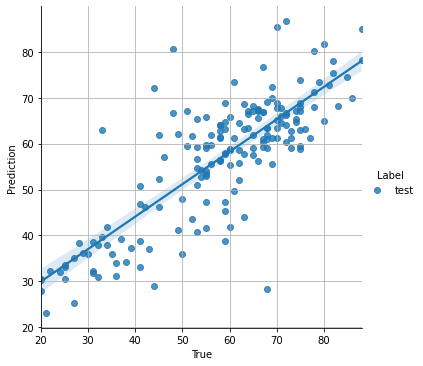

In [11]:
# TEST
tst_bth_loss = 0
model.eval()
tst_trues, tst_preds = [], []
with torch.no_grad(): # to not give loads on GPU... :(
    for i, (x, y) in enumerate(test_loader):
        if resize:
            x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

        else:
            x, y = x.to(device), y.to(device)

        y_pred = model.forward(x).to(device)

        tst_trues.append(y.to('cpu'))
        tst_preds.append(y_pred.to('cpu'))

        loss = loss_fn(y_pred.squeeze(1), y)
        del x, y, y_pred

        tst_bth_loss += loss.item()

torch.cuda.empty_cache()
### loss
tst_loss = tst_bth_loss / len(test_loader)

### collect trues/predictions
tst_trues = list(chain(*tst_trues))
tst_preds = list(chain(*tst_preds))

reg_df = pd.DataFrame({
    'True': list(map(float, tst_trues)),
    'Prediction': list(map(float, tst_preds)),
    'Label': ['test'] * len(tst_trues)
})

tst_corr = reg_df[reg_df['Label'] == 'test' ].corr().Prediction['True']
print(f'RMSE :: [VALID] {tst_loss:.3f}')
print(f'CORR :: [VALID] {tst_corr:.3f}')

sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
plt.grid()
plt.show()

In [30]:
trn_fold_losses_np = np.array(trn_fold_losses)
tst_fold_losses_np = np.array(tst_fold_losses)

trn_loss_avg = np.average(trn_fold_losses_np, axis=0)
trn_loss_std = np.std(trn_fold_losses_np, axis=0)

tst_loss_avg = np.average(tst_fold_losses_np, axis=0)
tst_loss_std = np.std(tst_fold_losses_np, axis=0)

plt.figure(figsize=(7, 4))
plt.title('Train/Valid Loss Among Epochs 100, Fold 10')

plt.plot(trn_loss_avg, label='Train')
plt.fill_between(range(100), trn_loss_avg-trn_loss_std, trn_loss_avg+trn_loss_std, alpha=.2)
plt.plot(tst_loss_avg, label='Valid')
plt.fill_between(range(100), tst_loss_avg-trn_loss_std, tst_loss_avg+trn_loss_std, alpha=.2)

plt.xlabel('Epochs')
plt.ylabel('RMSE loss')

plt.legend()
plt.ylim(5, 15)
plt.grid()

In [12]:
# trn_losses, tst_losses = [], []
# best_loss = 10

# for e in range(300):

#     # TRAIN
#     trn_bth_loss = 0
#     trn_trues, trn_preds = [], []
#     model.train()
#     for i, (x, y) in enumerate(train_loader):

#         if resize:
#             x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#         else:
#             x, y = x.to(device), y.to(device)

#         optimizer.zero_grad()

#         y_pred = model.forward(x).to(device)

#         trn_trues.append(y.to('cpu'))
#         trn_preds.append(y_pred.to('cpu'))

#         loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y)) # <- for MSE -> RMSE
# #         loss = loss_fn(y_pred.squeeze(1), y)
#         del x, y, y_pred

#         loss.backward()
#         optimizer.step()
#         if scheduler: scheduler.step()

#         trn_bth_loss += loss.item()

#     torch.cuda.empty_cache()
    
#     ### loss
#     trn_losses.append(trn_bth_loss / len(train_loader))

#     ### collect trues/predictions
#     trn_trues = list(chain(*trn_trues))
#     trn_preds = list(chain(*trn_preds))

        
#     # TEST
#     tst_bth_loss = 0
#     model.eval()
#     tst_trues, tst_preds = [], []
#     with torch.no_grad(): # to not give loads on GPU... :(
#         for i, (x, y) in enumerate(test_loader):
#             if resize:
#                 x, y = F.interpolate(x, size=(96, 96, 96)).to(device), y.to(device)

#             else:
#                 x, y = x.to(device), y.to(device)

#             y_pred = model.forward(x).to(device)

#             tst_trues.append(y.to('cpu'))
#             tst_preds.append(y_pred.to('cpu'))

#             loss = torch.sqrt(loss_fn(y_pred.squeeze(1), y)) # <- for MSE -> RMSE
# #             loss = loss_fn(y_pred.squeeze(1), y)
#             del x, y, y_pred

#             tst_bth_loss += loss.item()

#     torch.cuda.empty_cache()
#     ### loss
#     tst_losses.append(tst_bth_loss / len(test_loader))

#     ### collect trues/predictions
#     tst_trues = list(chain(*tst_trues))
#     tst_preds = list(chain(*tst_preds))
    
#     reg_df = pd.DataFrame({
#         'True': list(map(float, trn_trues + tst_trues)),
#         'Prediction': list(map(float, trn_preds + tst_preds)),
#         'Label': ['train'] * len(trn_trues) + ['test'] * len(tst_trues)
#     })
    
#     trn_corr = reg_df[reg_df['Label'] == 'train'].corr().Prediction['True']
#     tst_corr = reg_df[reg_df['Label'] == 'test' ].corr().Prediction['True']

#     print(f'EPOCHS {e}')
#     print(f'RMSE :: [TRAIN] {trn_losses[-1]:.3f} | [VALID] {tst_losses[-1]:.3f}')
#     print(f'CORR :: [TRAIN] {trn_corr:.3f} | [VALID] {tst_corr:.3f}')
    
#     sns.lmplot(data=reg_df, x='True', y='Prediction', hue='Label')
#     plt.grid()
#     plt.show()
    
#     if best_loss - .02 > tst_losses[-1]:
        
#         date = f'{datetime.now().strftime("%Y-%m-%d_%H%M")}'
#         fname = f"./models/{date}_{tst_losses[-1]:.3f}_model.pth"
#         torch.save(model, fname)
#         best_loss = min(tst_losses[-1], best_loss)
        
#     summary.add_scalars('loss/RMSE_loss',
#                          {'Train Loss': trn_losses[-1],
#                           'Valid Loss': tst_losses[-1]}, e)
#     summary.add_scalars('corr',
#                        {'Train Correlation': trn_corr,
#                         'Valid Correlation': tst_corr,
#                         'Total Correlation': reg_df.corr().Prediction['True']}, e)
    
#     if e % 20 == 0:
#         plt.plot(trn_losses, label='Train')
#         plt.plot(tst_losses, label='Valid')
#         plt.title(f"L1 Losses among epochs, {e}th")
#         #plt.ylim(0, 500)
#         plt.grid()
#         plt.legend()

In [13]:
best_loss

10

In [14]:
# %load ../2d_slice/src/slice_viewer.py

In [15]:
# SliceViewer(np.array(train_dset[0][0][0])).triple_view()